# University of Virginia, School of Data Science
## Final Project | DS 7200: Distributed Computing
### **Team 5:** Gia Smith (nqj5zk), Luz Melo (czj9zj), Meesun Yang (tby8aj)
#### **Due Date:** December 9th, 2023
---

**INSTRUCTIONS**

This code is divided into five steps:

1. Data import and preprocessing
2. Data splitting/sampling
3. Exploratory data analysis with at least 2 graphs
4. Model construction with at least 3 models
5. Model evaluation

# STEP 1: Data Import and Preprocessing

(Preprocessing include such tasks as imputing, binning, filtering, outlier treatment, feature engineering, 
text processing)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql.functions import year
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import mean, stddev, corr
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer 
from pyspark.sql.types import StructType, StructField, DateType, FloatType, LongType
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# set up the session
spark = SparkSession.builder.getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/09 20:39:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)
# List files in the current working directory
print("Files in Current Directory:", os.listdir())

Current Working Directory: /sfs/qumulo/qhome/tby8aj/DC_Final/KO
Files in Current Directory: ['KO_merged_data.csv', 'code-Copy1.ipynb', 'KO_1st_toLoad.csv', 'KOv3_v2.csv', 'KO_quarterly_balance-sheet.csv', 'KOv2.csv', 'KO_quarterly_valuation_measures.csv', 'KO_quarterly_financials.csv', 'KOv3.csv', 'KO_filtered_merged_data.csv', '.ipynb_checkpoints', 'data.txt', 'MY_models_histPrice_yest.ipynb', 'KO.csv', 'code_v3-Copy1.ipynb', 'MY_models_earnings.ipynb', 'KO_class.csv', 'code_v3.ipynb', 'code_v2.ipynb', 'code.ipynb', 'MY_models_histPrice_today.ipynb', 'KO_quarterly_cash-flow.csv']


## The Data

In [4]:
# Read in stock data. Source: Yahoo! finance
path1 = 'KO.csv'
path2 = 'KO_1st_toLoad.csv'
path3 = 'KO_quarterly_valuation_measures.csv'
path4 = 'KO_quarterly_financials.csv'
path5 = 'KO_quarterly_balance-sheet.csv'
path6 = 'KO_quarterly_cash-flow.csv'
path7 = 'KO_merged_data.csv'
path8 = 'filtered_merged_data.csv'
path9 = 'KO_filtered_merged_data.csv'
path10 = 'KOv3.csv'
path11 = 'KO_class.csv'

In [5]:
# set up schema
stock_schema = StructType([StructField('Date',DateType(),False),
                           StructField('Open',FloatType(),False),
                           StructField('High',FloatType(),False),
                           StructField('Low',FloatType(),False),
                           StructField('Close',FloatType(),False),
                           StructField('Adj Close',FloatType(),False),
                           StructField('Volume',FloatType(),False),
                         ])

### Historical Data: Daily Stock Price Data

In [6]:
df1 = spark.read.csv(path1, header=True, schema=stock_schema)
df1.show(5)

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528| 806400.0|
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400.0|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800.0|
|1962-01-05|0.259115| 0.26237|0.252604|0.253255| 0.046726|1420800.0|
|1962-01-08|0.251302|0.251302|0.245768|0.250651| 0.046246|2035200.0|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 5 rows



## Add columns for H3, L3, D

In [7]:
# Add Year column to use as partition column for efficient parallel processing
df1 = df1.withColumn("Year", year("Date"))

# Specify the partition column for performance
partition_column = "Year"

# Create a Window specification with partitionBy and orderBy
window_spec = Window().partitionBy(partition_column).orderBy("Date")

# Calculate H3 and L3 using the window functions
df1 = df1.withColumn("H3", F.max("Adj Close").over(window_spec.rowsBetween(-2, 0)))
df1 = df1.withColumn("L3", F.min("Adj Close").over(window_spec.rowsBetween(-2, 0)))

# Calculate the D line
df1 = df1.withColumn("D", 100 * (F.col("H3") / F.col("L3")))

# Create a binary class column based on the D line buy = 0, sell = 1
df1 = df1.withColumn("Class", F.when(F.col("D") > 102, 1).otherwise(0))

# Show the resulting DataFrame
df1.show(10)

+----------+--------+--------+--------+--------+---------+---------+----+--------+--------+------------------+-----+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|Year|      H3|      L3|                 D|Class|
+----------+--------+--------+--------+--------+---------+---------+----+--------+--------+------------------+-----+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528| 806400.0|1962|0.048528|0.048528|             100.0|    0|
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400.0|1962|0.048528|0.047447|102.27833376267827|    1|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800.0|1962|0.048528|0.047447|102.27833376267827|    1|
|1962-01-05|0.259115| 0.26237|0.252604|0.253255| 0.046726|1420800.0|1962|0.047807|0.046726| 102.3134893284376|    1|
|1962-01-08|0.251302|0.251302|0.245768|0.250651| 0.046246|2035200.0|1962|0.047807|0.046246|103.37542913014963|    1|
|1962-01-09|0.250651| 0.25651|0.248698|0.255208| 0.047087| 96000

In [8]:
df1.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- H3: float (nullable = true)
 |-- L3: float (nullable = true)
 |-- D: double (nullable = true)
 |-- Class: integer (nullable = false)



### Add columns for previous day and rate of return

In [9]:
from pyspark.sql.functions import year

# Add Year column to use as partition column for efficient parallel processing
df1a = df1.withColumn("Year", year("Date"))

# Specify the partition column for performance
partition_column = "Year"

# Create a Window specification with partitionBy and orderBy
window_spec = Window().partitionBy(partition_column).orderBy("Date")

# Calculate the rate of return using the lag function
df1a = df1a.withColumn("prev_Close", F.lag("Close").over(window_spec))
df1a = df1a.withColumn("prev_Adj_Close", F.lag("Adj Close").over(window_spec))
df1a = df1a.withColumn("prev_Open", F.lag("Open").over(window_spec))
df1a = df1a.withColumn("prev_High", F.lag("High").over(window_spec))
df1a = df1a.withColumn("prev_Low", F.lag("Low").over(window_spec))
df1a = df1a.withColumn("prev_Volume", F.lag("Volume").over(window_spec))

# Calculate the rate of return
df1a = df1a.withColumn("Rate_of_Return", ((df1a["Adj Close"] - df1a["prev_Adj_Close"]) / df1a["prev_Adj_Close"]))

# Drop rows with null values in the "Rate_of_Return" column
df1a = df1a.dropna(subset=["Rate_of_Return"])

df1a.show(5)

+----------+--------+--------+--------+--------+---------+---------+----+--------+--------+------------------+-----+----------+--------------+---------+---------+--------+-----------+--------------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|Year|      H3|      L3|                 D|Class|prev_Close|prev_Adj_Close|prev_Open|prev_High|prev_Low|prev_Volume|      Rate_of_Return|
+----------+--------+--------+--------+--------+---------+---------+----+--------+--------+------------------+-----+----------+--------------+---------+---------+--------+-----------+--------------------+
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400.0|1962|0.048528|0.047447|102.27833376267827|    1|  0.263021|      0.048528| 0.263021| 0.270182|0.263021|   806400.0|-0.02227582009660...|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800.0|1962|0.048528|0.047447|102.27833376267827|    1|  0.257161|      0.047447| 0.259115| 0.259115|0.253255|  1574400

## Historical Data: Quarterly Stock Price Data

In [10]:
df2 = spark.read.csv(path2, header=True, inferSchema=True)
df2.show(10)

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
| 3/31/1985|1.458333|1.505208|1.408854|1.427083| 0.565683|331833600|
| 6/30/1985|1.445313|1.559896|1.401042|1.505208| 0.603144|522912000|
| 9/30/1985|1.453125|1.510417|1.440104|1.492188| 0.604408|258590400|
|12/31/1985|1.760417|1.770833|1.598958|1.747396| 0.714215|288134400|
| 3/31/1986|  2.1875|     2.5|2.052083|2.322917| 0.957008|416294400|
| 6/30/1986|2.742188|2.804688|2.359375|2.445313| 1.014374|364022400|
| 9/30/1986|2.117188|2.453125|2.109375|2.289063| 0.956324|255110400|
|12/31/1986|2.359375|2.773438|2.359375|2.664063| 1.121004|392235200|
| 3/31/1987|2.859375|  2.9375|2.546875|2.664063| 1.128003|319137600|
| 6/30/1987|2.765625|2.992188|2.679688|2.976563| 1.268484|321331200|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 10 rows



## The following cells (up to Step 2) show how the four sets of various financial data were imported, merged, cleaned, and transformed to create the main dataframe of financial data.

### Valuation Measures

In [15]:
df3 = spark.read.csv(path3, header=True, inferSchema=True)
#df3.show(10)

### Income Statement

In [16]:
df4 = spark.read.csv(path4, header=True, inferSchema=True)
#df4.show(10)

### Balance Sheet

In [17]:
df5 = spark.read.csv(path5, header=True, inferSchema=True)
#df5.show(10)

### Cash Flow

In [18]:
df6 = spark.read.csv(path6, header=True, inferSchema=True)
#df6.show(10)

### Merged Datasets: Valuation Measures, Income Statement, Balance Sheet, and Cash Flow.

In [ ]:
merged_df = df3.join(df4, 'Date', 'inner') \
               .join(df5, 'Date', 'inner') \
               .join(df6, 'Date', 'inner')

# Save the merged DataFrame to a CSV file
#output_path = "merged_data.csv"
#merged_df.write.csv(output_path, header=True, mode="overwrite")
#len(merged_df.columns)

In [11]:
merged_df = spark.read.csv(path7, header=True, inferSchema=True)
len(merged_df.columns)
#merged_df.show(5)

214

### Removing columns with null values

In [12]:
# Identify columns without null values
columns_without_null = [col_name for col_name in merged_df.columns if merged_df.filter(col(col_name).isNull()).count() == 0]
# Identify columns with null values
columns_with_null = [col_name for col_name in merged_df.columns if merged_df.filter(col(col_name).isNull()).count() != 0]

# Select only columns without null values
filtered_merged_df = merged_df.select(*columns_without_null)

# Total number of columns without null values
len(columns_without_null)
len(filtered_merged_df.columns)

102

In [15]:
# Save the filtered merged DataFrame to a CSV file
#output_path = "filtered_merged_data.csv"
#filtered_merged_df.write.csv(output_path, header=True, mode="overwrite")

#filtered_merged_df = spark.read.csv(path8, header=True, inferSchema=True)
#len(filtered_merged_df.columns)

### Join filtered historical data and merged dataset to construct the final df for earnings financial data

In [13]:
#final_merged_df = df1.join(filtered_merged_df, 'Date', 'inner')
#df9 = final_merged_df
#len(df9.columns)

# Save the merged DataFrame to a CSV file
#output_path = "KO_filtered_merged_df.csv"
#final_merged_df.write.csv(output_path, header=True, mode="overwrite")

#df9 = spark.read.csv(path9, header=True, inferSchema=True)
#print(len(df9.columns))
#df9.show(1)

In [10]:
df10 = spark.read.csv(path10, header=True, inferSchema=True)
len(df10.columns)

109

### Add columns for year, previous day, and rate of return

In [11]:
# Set the configuration parameter to address warning on truncating the string representation of a plan since it was too large.
spark.conf.set("spark.sql.debug.maxToStringFields", 250) 

# Add Year column to use as partition column for efficient parallel processing
df10a = df10.withColumn("Year", year("Date"))

# Specify the partition column for performance
partition_column = "Year"

# Create a Window specification with partitionBy and orderBy
window_spec = Window().partitionBy(partition_column).orderBy("Date")

# Calculate the rate of return using the lag function
df10a = df10a.withColumn("prev_Close", F.lag("Close").over(window_spec))
df10a = df10a.withColumn("prev_Adj_Close", F.lag("Adj Close").over(window_spec))
df10a = df10a.withColumn("prev_Open", F.lag("Open").over(window_spec))
df10a = df10a.withColumn("prev_High", F.lag("High").over(window_spec))
df10a = df10a.withColumn("prev_Low", F.lag("Low").over(window_spec))
df10a = df10a.withColumn("prev_Volume", F.lag("Volume").over(window_spec))

# Calculate the rate of return
df10a = df10a.withColumn("Rate_of_Return", ((df10a["Adj Close"] - df10a["prev_Adj_Close"]) / df10a["prev_Adj_Close"]))

# Drop rows with null values in the "Rate_of_Return" column
df10a = df10a.dropna(subset=["Rate_of_Return"])
df10a.show(1)

+----------+--------+--------+--------+-------+---------+------------------+---------+-----------+---------------+-------+-------+-------+----------------------------+---------------------------+------------+----------------+-------------+-----------+----------------+-------------------------------+---------------+------------------+------------+------------+---------------------------+---------+-----------------------------------------+-----------------------------+-------------------------------+--------+----------+------------------+--------------------+------------------------------+-------------+-----------------------------------------------+----------------+---------+---------+-----------------------+----------------------+---------------------------------------------------+----------------+---------------+-----------------------+-----------+-------------+------------------------------------------+----------------------+-----------+---------+---------------------+----------+----

# STEP 2: Data Splitting and Sampling

(Sampling may not be needed, but splitting is a must)

For all the models we used 80% of the data for training and 20% of the data for testing. This is performed during the model construction as many different datasets are used for various models. Please refer to STEP 4: Model Construction. 

# STEP 3: Exploratory Data Analysis

(Include at least two graphs)

## Historical Data: Daily Stock Price

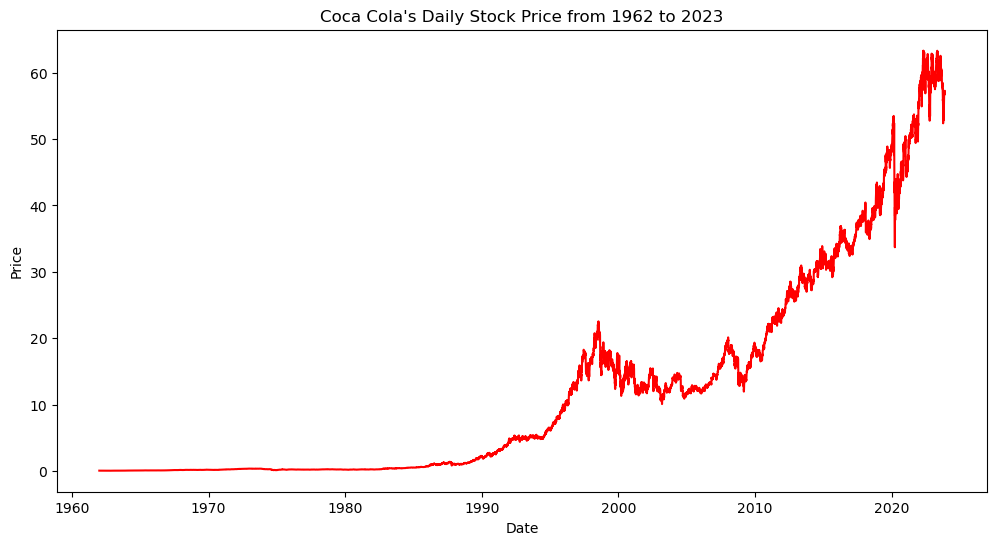

In [23]:
# Assuming 'Date' and 'Volume' are column names in your DataFrame
prices_and_volume = df1.select("Date", "Adj Close", "Volume").collect()
dates = [row.Date for row in prices_and_volume]
prices = [row["Adj Close"] for row in prices_and_volume]
volume = [row.Volume for row in prices_and_volume]

# Creating subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting stock prices on the first y-axis
ax1.plot(dates, prices, color='red', label='Stock Price')
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis='y')
ax1.set_title("Coca Cola's Daily Stock Price from 1962 to 2023")


# Displaying the plot
plt.show()

### Statistical Information

In [23]:
mean_price = df1.select(mean("Close")).first()[0]
stddev_price = df1.select(stddev("Close")).first()[0]
corr_price_volume = df1.select(corr("Close", "Volume")).first()[0]

print("Mean Price:", mean_price)
print("Standard Deviation Price:", stddev_price)
print("Correlation between Price and Volume:", corr_price_volume)

Mean Price: 17.44691300745597
Standard Deviation Price: 18.399699444096413
Correlation between Price and Volume: 0.47349443753791776


In [45]:
df1.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|           Volume|              Year|                H3|                L3|                 D|              Class|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|             15578|             15578|             15578|             15578|             15578|            15578|             15578|             15578|             15578|             15578|              15578|
|   mean|17.443087905915117|17.584551596108934| 17.29806420616332| 17.44691300745597|12.287431249795091|9212160.328668635|19

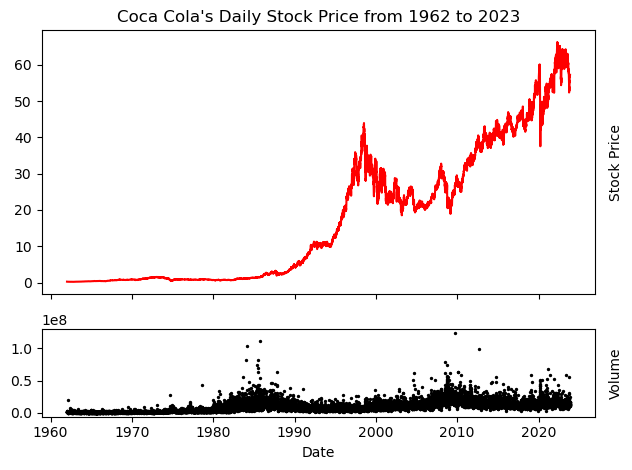

In [46]:
start_date = pd.to_datetime('1962-01-02')
end_date = pd.to_datetime('2023-11-17')

# Convert the 'Date' column to a datetime type in PySpark
df1 = df1.withColumn('Date', F.to_date(df1['Date']))

# Filter the DataFrame based on the date range
df2 = df1.filter((df1['Date'] >= start_date) & (df1['Date'] <= end_date))

# Convert the filtered DataFrame to a Pandas DataFrame for plotting
pd_df2 = df2.toPandas()

# Set the 'Date' column as the index
pd_df2.set_index('Date', inplace=True)

# Plotting
fig, (top_plt, bottom_plt) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Top plot (stock prices)
top_plt.plot(pd_df2.index, pd_df2["Close"], color='red')
top_plt.set_title("Coca Cola's Daily Stock Price from 1962 to 2023")
top_plt.set_ylabel('Stock Price')

# Bottom plot (volume)
bottom_plt.scatter(pd_df2.index, pd_df2['Volume'], color = "black", s=2)
bottom_plt.set_ylabel('Volume')

# Add x-axis label to the bottom plot
bottom_plt.set_xlabel('Date')

# Add labels on the right side
top_plt.yaxis.set_label_coords(1.05, 0.5)
bottom_plt.yaxis.set_label_coords(1.05, 0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Historical Data: Quarterly Earnings

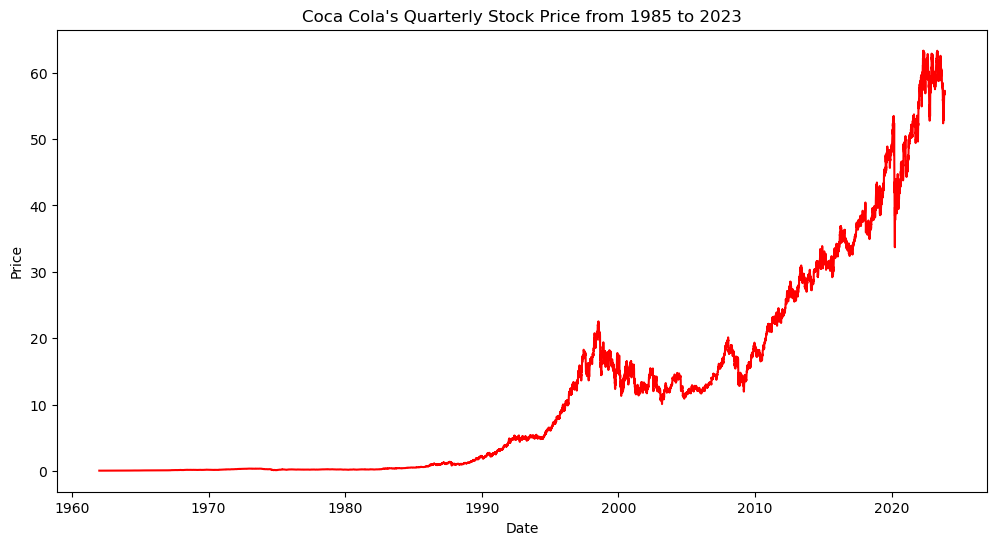

In [26]:
# Imports
import matplotlib.pyplot as plt

# Assuming 'Date' and 'Volume' are column names in your DataFrame
prices_and_volume = df2.select("Date", "Adj Close", "Volume").collect()
dates = [row.Date for row in prices_and_volume]
prices = [row["Adj Close"] for row in prices_and_volume]
volume = [row.Volume for row in prices_and_volume]

# Creating subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting stock prices on the first y-axis
ax1.plot(dates, prices, color='red', label='Stock Price')
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis='y')
ax1.set_title("Coca Cola's Quarterly Stock Price from 1985 to 2023")


# Displaying the plot
plt.show()

### Statistical Information

In [14]:
mean_price = df2.select(mean("Close")).first()[0]
stddev_price = df2.select(stddev("Close")).first()[0]
corr_price_volume = df2.select(corr("Close", "Volume")).first()[0]

print("Mean Price:", mean_price)
print("Standard Deviation Price:", stddev_price)
print("Correlation between Price and Volume:", corr_price_volume)

Mean Price: 27.52109156129032
Standard Deviation Price: 16.84658531333408
Correlation between Price and Volume: 0.1867645283947028


In [15]:
df2.describe().show()

+-------+----------+------------------+------------------+------------------+-----------------+-----------------+-------------------+
|summary|      Date|              Open|              High|               Low|            Close|        Adj Close|             Volume|
+-------+----------+------------------+------------------+------------------+-----------------+-----------------+-------------------+
|  count|       155|               155|               155|               155|              155|              155|                155|
|   mean|      null|27.242385083870964|28.556678051612906|26.130075341935488|27.52109156129032|19.63907499354838|        2.6775922E8|
| stddev|      null| 16.55460946000394|17.283573192937954|16.098500416012087|16.84658531333408|16.30285868924161|1.165500545427025E8|
|    min|12/31/1985|          1.445313|          1.505208|          1.401042|         1.427083|         0.565683|           95362800|
|    max| 9/30/2023|         63.560001|         67.199997|    

## Questions to Analyze Using PySpark

In this section, we will address some questions about the data using PySpark’s data preprocessing techniques.

- What is the average adjusted closing price?
- On what day stock price was the highest?
- For how many days the adjusted closing value was less than the average?
- On what days was the volume the higest? Show the top 20 dates.
- What is the maximum and minimum volume of stock traded?

**What is the average adjusted closing price?**

In [26]:
from pyspark.sql.functions import avg

# Calculate the average closing price
avg_close = df1.select(avg("Close")).first()[0]

print(f"The average closing price is: {avg_close}")

The average closing price is: 17.44691300745597


**On what day stock price was the highest?**

In [27]:
from pyspark.sql.functions import col, max

# Assuming the closing price column is named 'Close'
max_close_row = df1.select("Date", "Adj Close").orderBy(col("Adj Close").desc()).first()

print(f"On {max_close_row['Date']}, the stock price was the highest: {max_close_row['Adj Close']}")

On 2022-04-21, the stock price was the highest: 63.318031311035156


**For how many days the adjusted closing value was less than the average?**

In [28]:
# Filter the days where the closing value was less than the average
below_avg_days = df1.filter(col("Adj Close") < avg_close).count()

# Calculate the total number of days
total_days = df1.count()

# Calculate the percentage
percentage_below_avg = (below_avg_days / total_days) * 100

print(f"For {below_avg_days} days, the adjusted closing value was less than the average.")
print(f"This is {percentage_below_avg:.2f}% of the total days.")

For 11658 days, the adjusted closing value was less than the average.
This is 74.84% of the total days.


**On what days was the volume the higest? Show the top 20 dates.**

In [34]:
# register stock dataFrame as temp view with name "stocks"
df1.createOrReplaceTempView("stocks")

# query the view to get the top 20 dates with the highest volume
sqlDF1 = spark.sql("SELECT * FROM stocks ORDER BY Volume DESC LIMIT 20")
sqlDF1.select('Date','Open','High','Low','Close','Adj Close','Volume').show()

+----------+--------+--------+--------+--------+---------+-----------+
|      Date|    Open|    High|     Low|   Close|Adj Close|     Volume|
+----------+--------+--------+--------+--------+---------+-----------+
|2009-09-18|   26.84|   27.06|   26.65|   26.88|17.449154|  1.24169E8|
|1985-09-09|1.463542|1.476563|1.427083|  1.4375| 0.576012|  1.10784E8|
|1984-03-15|1.117188|1.122396|1.117188|1.122396| 0.425084|  1.03776E8|
|2012-09-21|   38.73|   38.74|   37.88|   38.03|26.943003|9.8967504E7|
|1985-06-10|1.445313|1.445313|1.427083|1.432292| 0.567748|   8.2656E7|
|1984-01-12|1.111979|1.114583|1.052083|1.065104| 0.398109|  8.16096E7|
|2008-07-17|    25.6|   25.68|   24.85|   25.17|15.655744|  7.92144E7|
|1985-04-25|1.434896|1.445313|1.408854|1.416667| 0.561554|   7.3968E7|
|2008-10-10|  21.025|  22.525|  20.145|   20.75|12.998294|  7.35672E7|
|1985-07-10| 1.46875|1.515625| 1.46875|1.507813| 0.604187|   6.9264E7|
|2021-03-19|   50.46|   51.08|   50.17|   50.81| 47.13688|6.7845696E7|
|2010-

**What is the maximum and minimum volume of stock traded?**

In [30]:
from pyspark.sql.functions import desc, asc

# Assuming 'Date' and 'Volume' are column names in your DataFrame
max_volume_row = df1.orderBy(desc('Volume')).first()
min_volume_row = df1.orderBy(asc('Volume')).first()

# Extracting date and volume information
max_volume_date = max_volume_row['Date']
max_volume_value = max_volume_row['Volume']

min_volume_date = min_volume_row['Date']
min_volume_value = min_volume_row['Volume']

# Printing the results
print(f"On {max_volume_date}, the maximum volume of {max_volume_value} stocks was traded.")
print(f"On {min_volume_date}, the minimum volume of {min_volume_value} stocks was traded.")

On 2009-09-18, the maximum volume of 124169000.0 stocks was traded.
On 1963-10-16, the minimum volume of 76800.0 stocks was traded.


## Financial Earnings Data: Quarterly

### Correlation between independent variables and target variable

Correlation is a statistical measure that quantifies the degree to which two variables are related. A high positive correlation indicates a strong positive relationship, while a high negative correlation indicates a strong negative relationship. In here, we will look at the features with the highest correlation.

In [31]:
feature_columns = df9.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')
# Convert the TaxEffectOfUnusualItems column from string to double 
df9 = df9.withColumn("TaxEffectOfUnusualItems", col("TaxEffectOfUnusualItems").cast("double"))

In [32]:
import six
import pandas as pd

correlation_list = []

# iterate through the columns of the DataFrame
for i in feature_columns:
    # check if the column is not a string type
    if not isinstance(df10.select(i).take(1)[0][0], six.string_types):
        # calculate the correlation with 'Adj Close'
        correlation_value = df10.stat.corr('Adj Close', i)
        
        # append the pair (feature, correlation) to the list
        correlation_list.append((i, correlation_value))

# convert the list to a DataFrame
correlation_df = pd.DataFrame(correlation_list, columns=['Feature', 'Correlation'])

# sort the DataFrame by absolute correlation in descending order
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

print(correlation_df.head(10))

                                          Feature  Correlation
3                                           Close     0.969214
2                                             Low     0.968765
0                                            Open     0.962377
1                                            High     0.962049
7                                 EnterpriseValue     0.958147
64  TotalNonCurrentLiabilitiesNetMinorityInterest     0.944083
6                                       MarketCap     0.937978
66                                   LongTermDebt     0.937168
65          LongTermDebtAndCapitalLeaseObligation     0.937168
69                     OtherNonCurrentLiabilities     0.925659


# STEP 4: Model Construction

## Regression: Linear Regression, Gradient-boosted trees, and Random Forest

## Linear Regression

### Linear Regression: Historical Data

In [12]:
# To predict the adjusted close price, we will use the previous day's price data.

target_column = "Adj Close"
features_columns = ["prev_Open", "prev_High", "prev_Low", "prev_Adj_Close", "prev_Volume"]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")

# Scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize the logistic regression model
lr = GeneralizedLinearRegression(labelCol=target_column, featuresCol="scaledFeatures",
                      family="gaussian", link="identity",
                      maxIter=10,
                      regParam=0.3) 

# Create a pipeline with the assembler, scaler, and the logistic regression model
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing sets
(train_data, test_data) = df1a.randomSplit([0.8, 0.2], seed=1234)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on test set
prediction = model.transform(test_data)
prediction = prediction.withColumn('prediction', F.abs(prediction['prediction']))
prediction.select('Date','Adj Close','prediction').show(10, False)

ev = RegressionEvaluator(predictionCol="prediction", labelCol="Adj Close")

print("METRICS")
print("MAE:", ev.evaluate(prediction, {ev.metricName:'mae'}))
print("Root Mean Squared Error:", ev.evaluate(prediction, {ev.metricName: "rmse"}))
print("R Squared:", ev.evaluate(prediction, {ev.metricName:'r2'}))

+----------+---------+-------------------+
|Date      |Adj Close|prediction         |
+----------+---------+-------------------+
|1962-01-04|0.047807 |0.3633785120030282 |
|1962-01-09|0.047087 |0.36969782966749987|
|1962-02-01|0.045165 |0.3709083845544256 |
|1962-02-06|0.045045 |0.3566648604712113 |
|1962-02-07|0.045285 |0.3598207668098097 |
|1962-02-08|0.045405 |0.35572962858722756|
|1962-02-09|0.045645 |0.36041068823140426|
|1962-02-23|0.043963 |0.3610375534977619 |
|1962-03-08|0.044204 |0.36156643065875627|
|1962-03-12|0.044684 |0.36596063002551527|
+----------+---------+-------------------+
only showing top 10 rows

METRICS
MAE: 0.604648805782189
Root Mean Squared Error: 0.9042864982889584
R Squared: 0.9966179141073948


In [13]:
# To predict the rate of return, we will also use the previous day's price data.

target_column = "Rate_of_Return"
features_columns = ["prev_Open", "prev_High", "prev_Low", "prev_Adj_Close", "prev_Volume"]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")

# Scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize the logistic regression model
lr = GeneralizedLinearRegression(labelCol=target_column, featuresCol="scaledFeatures",
                      family="gaussian", link="identity",
                      maxIter=10,
                      regParam=0.3) 

# Create a pipeline with the assembler, scaler, and the logistic regression model
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing sets
(train_data, test_data) = df10a.randomSplit([0.8, 0.2], seed=1234)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on test set
prediction = model.transform(test_data)
prediction.select('Date','Rate_of_Return','prediction').show(10, False)

ev = RegressionEvaluator(predictionCol="prediction", labelCol="Rate_of_Return")

print("METRICS")
print("MAE:", ev.evaluate(prediction, {ev.metricName:'mae'}))
print("Root Mean Squared Error:", ev.evaluate(prediction, {ev.metricName: "rmse"}))
print("R Squared:", ev.evaluate(prediction, {ev.metricName:'r2'}))

+----------+---------------------+----------------------+
|Date      |Rate_of_Return       |prediction            |
+----------+---------------------+----------------------+
|12/31/1991|0.6156673982918835   |0.23654115117708735   |
|12/31/1994|0.3070096564691002   |0.2025007063276023    |
|12/31/2011|0.10549693783520443  |0.0721856695882524    |
|12/31/2014|0.12120420403573104  |0.015527312556745138  |
|12/31/2015|0.07720973899643305  |-0.0019522622929116773|
|12/31/2016|3.848496334341728E-6 |-0.0021531953015208605|
|12/31/2017|0.18331281108186068  |-0.0028150019249367775|
|3/31/1992 |0.5974450496493805   |0.2292055935185787    |
|3/31/2001 |-0.009806972144765735|0.12336556298121382   |
|3/31/2003 |-0.25902536911805546 |0.10320843721450584   |
+----------+---------------------+----------------------+
only showing top 10 rows

METRICS
MAE: 0.15767139054082255
Root Mean Squared Error: 0.19474760395577043
R Squared: 0.06363238971933338


### Linear Regression: Financial Earnings Data on subset of columns

In [14]:

target_column = "Adj Close"
features_columns = ["PeRatio", "PsRatio", "PbRatio","TotalRevenue","GrossProfit", 
                    "EnterprisesValueRevenueRatio", "EnterprisesValueEBITDARatio", "OperatingExpense", 
                    "OperatingIncome", "NetIncome", "BasicEPS", "TotalExpenses", 
                    "NormalizedIncome", "EBIT", "EBITDA", "TotalAssets", "CashAndCashEquivalents", 
                    "NetPPE", "GrossPPE", "TotalDebt", "RetainedEarnings"]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")

# Scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize the logistic regression model
lr = GeneralizedLinearRegression(labelCol=target_column, featuresCol="scaledFeatures",
                      family="gaussian", link="identity",
                      maxIter=10,
                      regParam=0.3) 

# Create a pipeline with the assembler, scaler, and the logistic regression model
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing sets
(train_data, test_data) = df10a.randomSplit([0.8, 0.2], seed=1234)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on test set
prediction = model.transform(test_data)
prediction = prediction.withColumn('prediction', F.abs(prediction['prediction']))
prediction.select('Date','Adj Close','prediction').show(10, False)

ev = RegressionEvaluator(predictionCol="prediction", labelCol="Adj Close")

print("METRICS")
print("MAE:", ev.evaluate(prediction, {ev.metricName:'mae'}))
print("Root Mean Squared Error:", ev.evaluate(prediction, {ev.metricName: "rmse"}))
print("R Squared:", ev.evaluate(prediction, {ev.metricName:'r2'}))

+----------+---------+------------------+
|Date      |Adj Close|prediction        |
+----------+---------+------------------+
|12/31/1991|4.564611 |5.8493222128638225|
|12/31/1994|6.481538 |4.759656800725701 |
|12/31/2011|23.427187|21.544250568750474|
|12/31/2014|31.117046|29.413940336625426|
|12/31/2015|33.519585|35.483646582491104|
|12/31/2016|33.519714|36.74864584811755 |
|12/31/2017|39.664307|34.040191483966986|
|3/31/1992 |4.905971 |5.383295165073634 |
|3/31/2001 |12.216757|12.630485780254876|
|3/31/2003 |11.048383|12.31663551851467 |
+----------+---------+------------------+
only showing top 10 rows

METRICS
MAE: 2.348287027912123
Root Mean Squared Error: 3.243875140132284
R Squared: 0.955447565922012


In [15]:

target_column = "Rate_of_Return"
features_columns = ["PeRatio", "PsRatio", "PbRatio","TotalRevenue","GrossProfit", 
                    "EnterprisesValueRevenueRatio", "EnterprisesValueEBITDARatio", "OperatingExpense", 
                    "OperatingIncome", "NetIncome", "BasicEPS", "TotalExpenses", 
                    "NormalizedIncome", "EBIT", "EBITDA", "TotalAssets", "CashAndCashEquivalents", 
                    "NetPPE", "GrossPPE", "TotalDebt", "RetainedEarnings"]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")

# Scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize the logistic regression model
lr = GeneralizedLinearRegression(labelCol=target_column, featuresCol="scaledFeatures",
                      family="gaussian", link="identity",
                      maxIter=10,
                      regParam=0.3) 

# Create a pipeline with the assembler, scaler, and the logistic regression model
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data into training and testing sets
(train_data, test_data) = df10a.randomSplit([0.8, 0.2], seed=42)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on test set
prediction = model.transform(test_data)
prediction.select('Date','Rate_of_Return','prediction').show(10, False)

ev = RegressionEvaluator(predictionCol="prediction", labelCol="Rate_of_Return")

print("METRICS")
print("MAE:", ev.evaluate(prediction, {ev.metricName:'mae'}))
print("Root Mean Squared Error:", ev.evaluate(prediction, {ev.metricName: "rmse"}))
print("R Squared:", ev.evaluate(prediction, {ev.metricName:'r2'}))

+----------+---------------------+-------------------+
|Date      |Rate_of_Return       |prediction         |
+----------+---------------------+-------------------+
|12/31/1992|0.10833080847415028  |0.09758119390153933|
|12/31/1996|0.5519744760704154   |0.1790154854835449 |
|12/31/1998|0.01722689314537907  |0.18028185868415128|
|12/31/2003|0.24187836296458798  |0.09059067478801644|
|12/31/2009|0.31414460167181607  |0.06721577547703275|
|12/31/2013|0.04475541439220446  |0.07423225436692349|
|12/31/2019|0.2518277702529362   |0.1352499668893768 |
|3/31/1991 |0.40912250564014063  |0.06061973582429611|
|3/31/2001 |-0.009806972144765735|0.09721637441396516|
|3/31/2002 |0.22050467239382757  |0.1118826934817389 |
+----------+---------------------+-------------------+
only showing top 10 rows

METRICS
MAE: 0.14857002564092667
Root Mean Squared Error: 0.18369063024721355
R Squared: -0.004431304355283272


## Gradient-boosted Trees

### Gradient-boosted Trees: Historical Daily Stock Price Data

In [16]:
df1.show(1)

+----------+--------+--------+--------+--------+---------+--------+----+--------+--------+-----+-----+
|      Date|    Open|    High|     Low|   Close|Adj Close|  Volume|Year|      H3|      L3|    D|Class|
+----------+--------+--------+--------+--------+---------+--------+----+--------+--------+-----+-----+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528|806400.0|1962|0.048528|0.048528|100.0|    0|
+----------+--------+--------+--------+--------+---------+--------+----+--------+--------+-----+-----+
only showing top 1 row



In [18]:
#feature_columns = df1.columns
#feature_columns.remove('Adj Close')
#feature_columns.remove('Date')
feature_columns = ["Open", "High", "Low", "Volume"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df1.randomSplit([0.8, 0.2], seed=1234)

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

Root Mean Squared Error (RMSE) on the test data: 1.2218787260313106
R-Squared on the test data: 0.9939558889753741
MAE on the test data: 0.6114910290272416


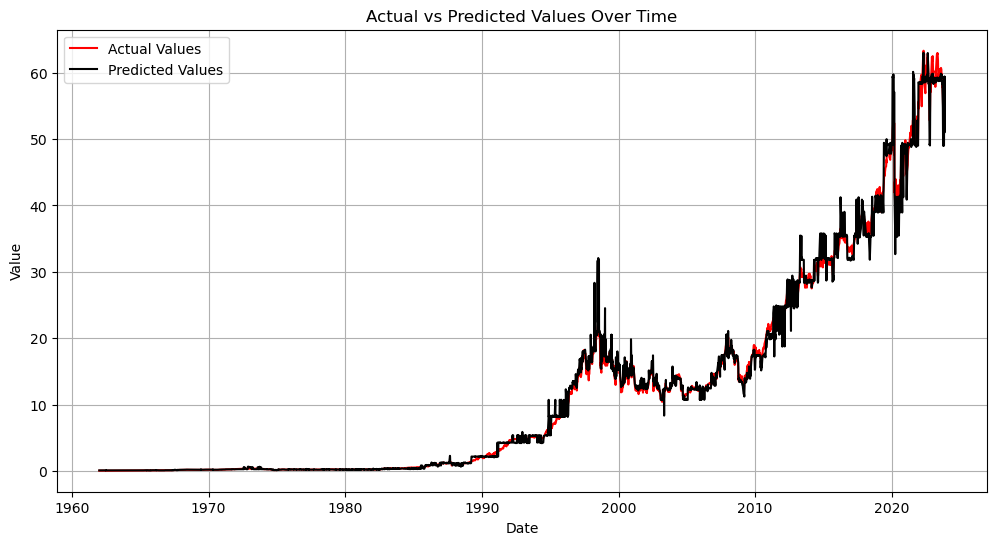

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Experiment: Can more features compensate for less data?

### Gradient-boosted Trees: Financial Earnings Data (all columns)

In [20]:
feature_columns = df10.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')

# Convert the TaxEffectOfUnusualItems column from string to double 
df10 = df10.withColumn("TaxEffectOfUnusualItems", col("TaxEffectOfUnusualItems").cast("double"))
#df10. printSchema()

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

Root Mean Squared Error (RMSE) on the test data: 3.273395774607916
R-Squared on the test data: 0.8830425082293992
MAE on the test data: 2.8027980701128072


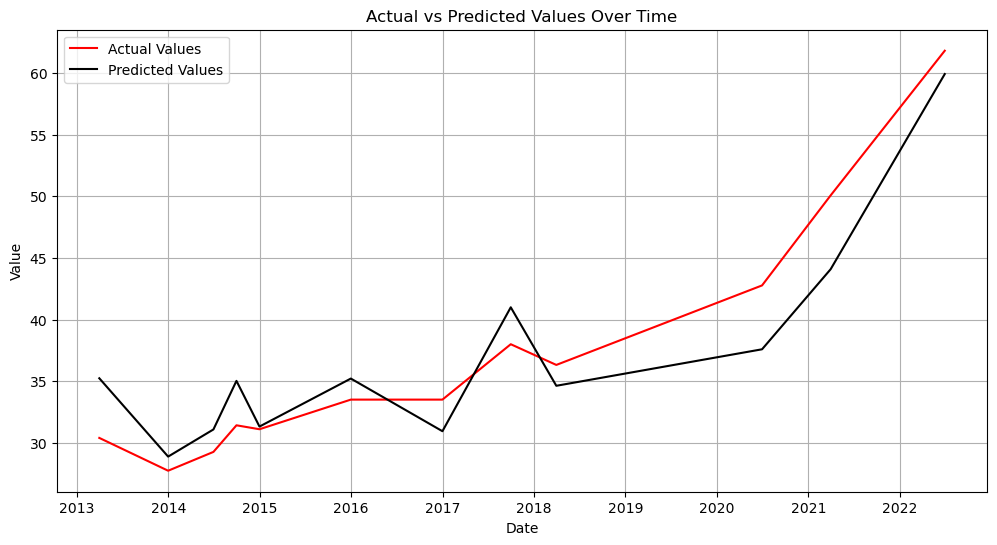

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Gradient-boosted Trees: Financial Earnings Data (Open, High, Low, Volume)

In [22]:
df10 = spark.read.csv(path10, header=True, inferSchema=True)
# Convert the TaxEffectOfUnusualItems column from string to double 
df10 = df10.drop("TaxEffectOfUnusualItems")
#df10. printSchema()

feature_columns = ['Open', 'High', 'Low', 'Volume']

In [23]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

Root Mean Squared Error (RMSE) on the test data: 1.6245708867863211
R-Squared on the test data: 0.9863670080970188
MAE on the test data: 1.2661382181683607


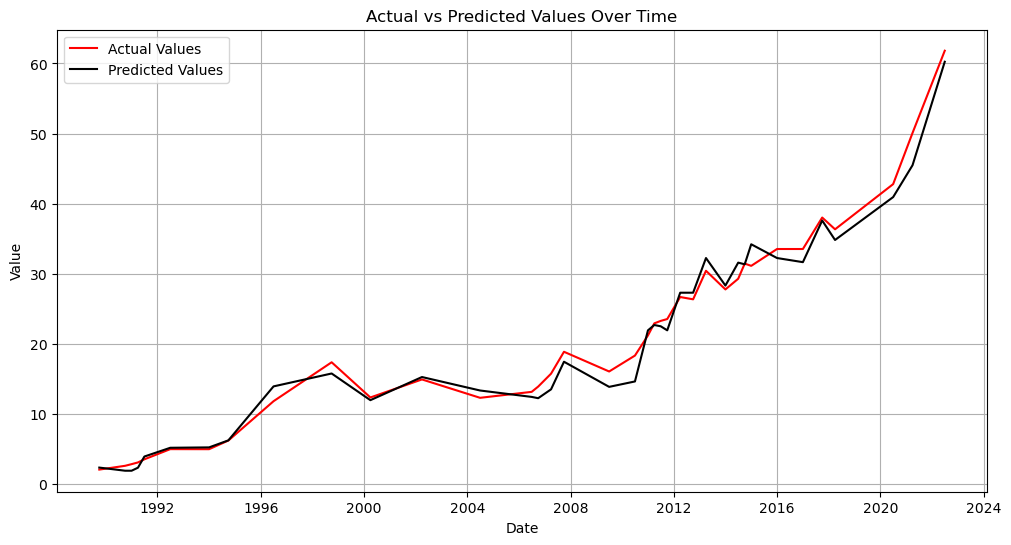

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

### Random Forest: Historical Data

In [25]:
#feature_columns = df1.columns
#feature_columns.remove('Adj Close')
#feature_columns.remove('Date')
feature_columns = ["Open", "High", "Low", "Volume"]
df1 = df1.orderBy(col('Date'))

In [26]:
# Define the feature assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df1.randomSplit([0.8, 0.2], seed=1234)

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol="Adj Close", numTrees=100, maxDepth=5, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

Root Mean Squared Error (RMSE) on the test data: 1.3519378238073987
R-Squared on the test data: 0.9926007165614084
MAE on the test data: 0.7414244654392196


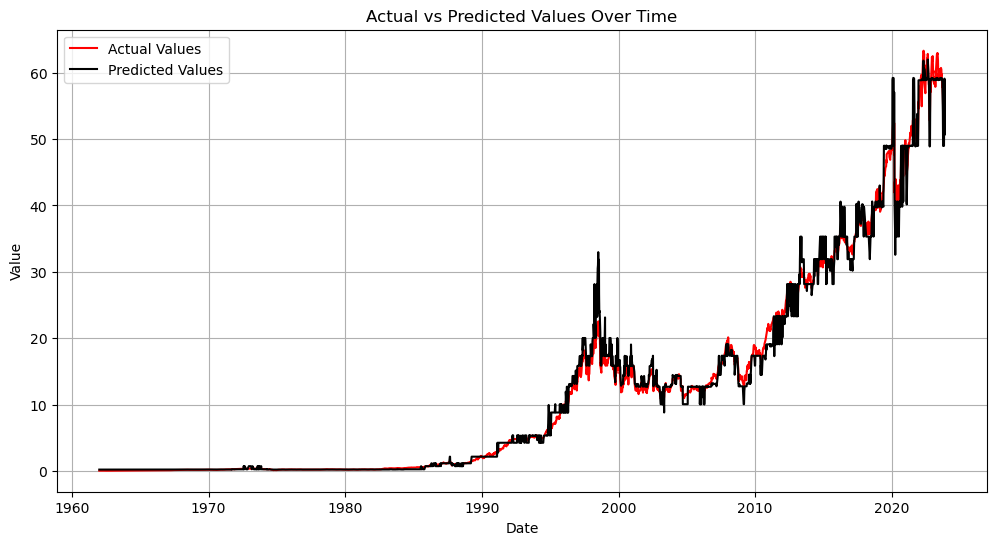

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest: Financial Earnings Data (all columns)

In [37]:
feature_columns = df10.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Close')
feature_columns.remove('Date')

In [38]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol="Adj Close", numTrees=100, maxDepth=5, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

Root Mean Squared Error (RMSE) on the test data: 1.2651000115524824
R-Squared on the test data: 0.991732702542472
MAE on the test data: 1.0021435858636547


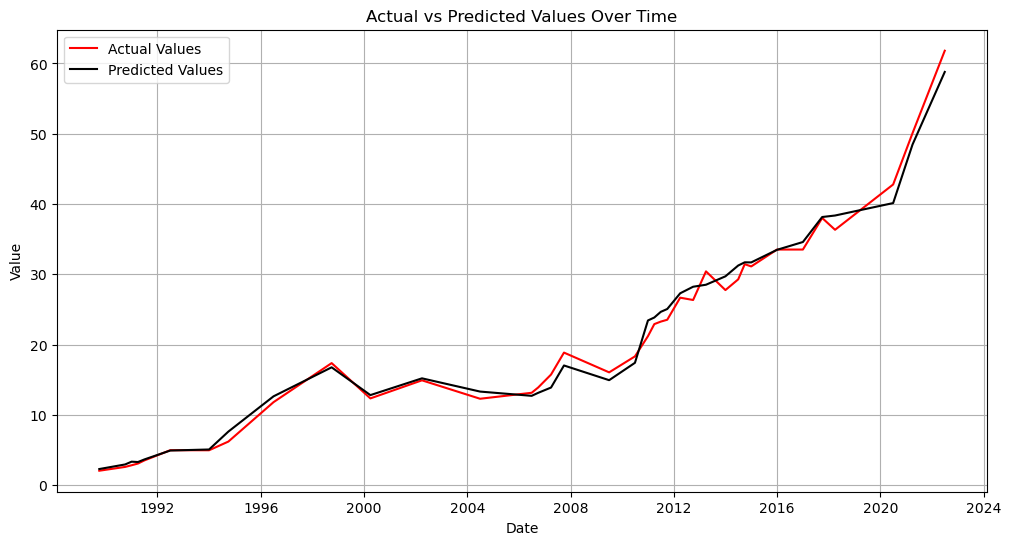

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Experiment: Does feature extraction improves the performance? Extract the top 4 features

### Feature Importance

In [39]:
# Extract feature importance from the trained RF model
feature_importance = model.stages[-1].featureImportances

# Create a Pandas DataFrame for better visualization
feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance)), columns=['Feature', 'Importance'])

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Consider only the top 4 features
top_4_features = feature_importance_df.head(4)

# Print or visualize the top 10 feature importance
print(top_4_features)

                                Feature  Importance
2                                   Low    0.104111
55  TotalLiabilitiesNetMinorityInterest    0.096869
79                 OrdinarySharesNumber    0.081698
29                   BasicAverageShares    0.073289


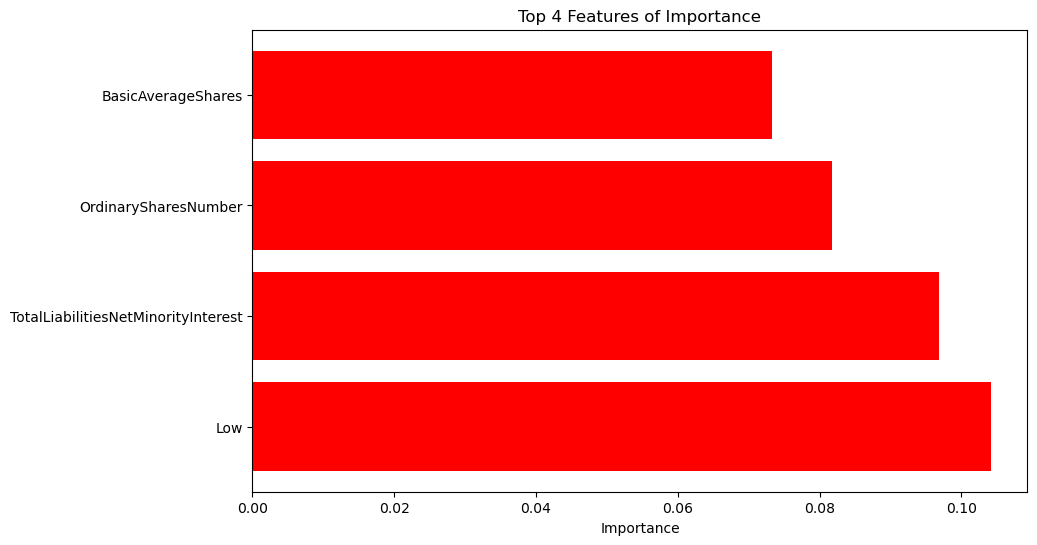

In [40]:
import matplotlib.pyplot as plt

# Assuming you have the 'top_10_features' DataFrame from your code

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_4_features['Feature'], top_4_features['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Top 4 Features of Importance')
plt.show()

### Random Forest: Financial Earnings Data (top 4 importance features)

In [42]:
# Extract the top 10 features as a list of tuples
feature_columns = top_4_features['Feature'].values.tolist()

# Print the list
print(feature_columns)

['Low', 'TotalLiabilitiesNetMinorityInterest', 'OrdinarySharesNumber', 'BasicAverageShares']


In [43]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)


# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

Root Mean Squared Error (RMSE) on the test data: 1.5347088399079443
R-Squared on the test data: 0.9878334951454119
MAE on the test data: 1.0611790795516813


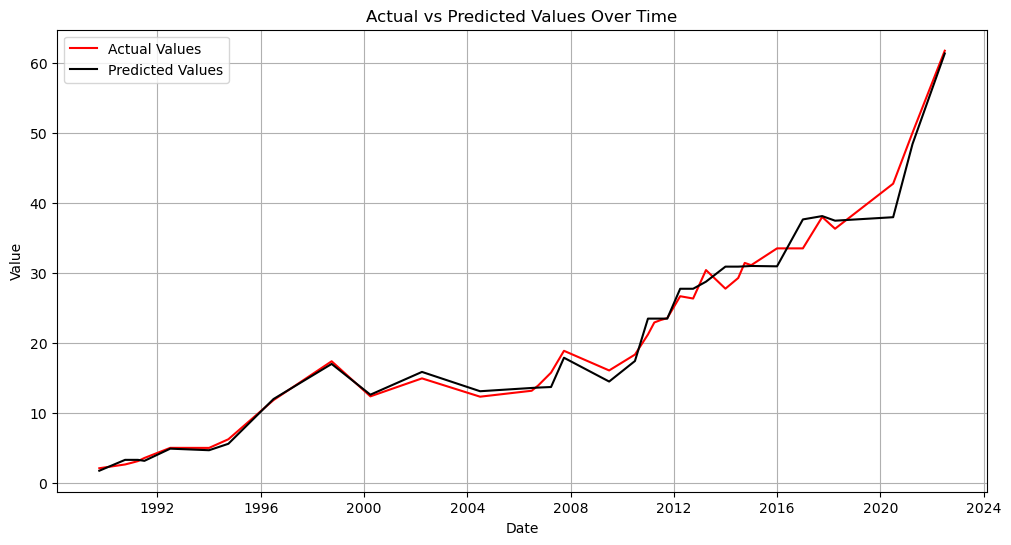

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Classification: Naive Bayes and Support Vector Machines (SVM)

### Buy or Sell?

https://www.investopedia.com/articles/technical/073001.asp

Using the stochastics %D line formula:
$D= 100 \bigg (\frac{H3}{L3} \bigg)$ 

Where, H3 is the Highest of the three previous stock prices and L3 is the lowest price in the same three day period as shown in df11 below.

In [28]:
df1.show(5)

+----------+--------+--------+--------+--------+---------+---------+----+--------+--------+------------------+-----+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|Year|      H3|      L3|                 D|Class|
+----------+--------+--------+--------+--------+---------+---------+----+--------+--------+------------------+-----+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528| 806400.0|1962|0.048528|0.048528|             100.0|    0|
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400.0|1962|0.048528|0.047447|102.27833376267827|    1|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800.0|1962|0.048528|0.047447|102.27833376267827|    1|
|1962-01-05|0.259115| 0.26237|0.252604|0.253255| 0.046726|1420800.0|1962|0.047807|0.046726| 102.3134893284376|    1|
|1962-01-08|0.251302|0.251302|0.245768|0.250651| 0.046246|2035200.0|1962|0.047807|0.046246|103.37542913014963|    1|
+----------+--------+--------+--------+--------+---------+------

### Naive Bayes

In [29]:
# Drop unnecessary columns
nb_df = df1.drop("Date", "label", "D", "Year")

outcome = "Class"

# Compile all columns that are not the outcome
feature_cols = [col for col in nb_df.columns if col not in [outcome, "label"]]

# Convert the "Class" column to a numeric type using StringIndexer
indexer = StringIndexer(inputCol=outcome, outputCol="label")
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="nb_features")

# Create a vector assembler
scaler = StandardScaler(inputCol="nb_features", outputCol="scaledFeatures")
naive_bayes = NaiveBayes(featuresCol="scaledFeatures", labelCol="label", smoothing=0.001)

# Create a pipeline with all the stages
pipeline = Pipeline(stages=[indexer, vector_assembler, scaler, naive_bayes])

# Split the data into training and testing sets
train_data, test_data = nb_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Print the area under ROC
print(f"Area under ROC: {area_under_roc}")
predictions.select("label", "prediction").show()

Area under ROC: 0.5164978407780125
+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [30]:
predictions.show(2)

+--------+--------+--------+--------+---------+---------+--------+--------+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    Open|    High|     Low|   Close|Adj Close|   Volume|      H3|      L3|Class|label|         nb_features|      scaledFeatures|       rawPrediction|         probability|prediction|
+--------+--------+--------+--------+---------+---------+--------+--------+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|0.193359|0.195964|0.191406|0.192708| 0.036048|2227200.0|0.036536|0.036048|    0|  0.0|[0.19335900247097...|[0.01049846007380...|[-1.0173795292389...|[0.66856842684102...|       0.0|
|0.195313|0.195638|0.187826|0.193359|  0.03617|5721600.0|0.037084| 0.03617|    1|  1.0|[0.19531300663948...|[0.01060455306397...|[-1.8877966564841...|[0.62183169961472...|       0.0|
+--------+--------+--------+--------+---------+---------+--------+--------+-----+----

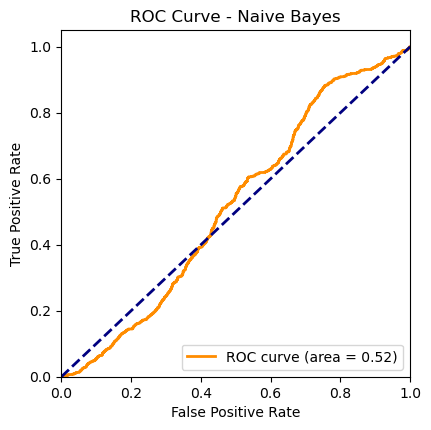

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("label", "rawPrediction").toPandas()

# Get the probability column from predictions_pd
probs = np.array(predictions_pd[["label", "rawPrediction"]].apply(lambda row: (float(row['rawPrediction'][1]), float(row['label'])), axis=1).tolist())

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(probs[:,1], probs[:,0])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4.5, 4.5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Support vector Machine (SVM)

In [32]:

# Drop unnecessary columns
svm_df = df1.drop("label","Date", "D", "Year")

# Define outcome and feature columns
outcome = "Class"
feature_cols = [col for col in svm_df.columns if col not in outcome]

# Vector assembler for feature transformation
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="svm_features")
svm_assembled = vector_assembler.transform(svm_df)

# Transform the DataFrame using the vector assembler
nb_assembled = vector_assembler.transform(nb_df)

scaler = StandardScaler(inputCol="svm_features", outputCol="scaledFeatures")
scalerModel = scaler.fit(svm_assembled)
scaledData = scalerModel.transform(svm_assembled)

# Split the data into training and testing sets
train_data, test_data = scaledData.randomSplit([0.8, 0.2], seed=1234)

# Linear SVM model
svm_classifier = LinearSVC(featuresCol="svm_features", labelCol="Class", maxIter=10)
svm_model = svm_classifier.fit(train_data)

# Make predictions on the test set
svm_predictions = svm_model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
SVM_evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area_under_roc = SVM_evaluator.evaluate(svm_predictions)

# Print the area under ROC
print(f"Area under ROC: {area_under_roc}")
svm_predictions.select("Class", "prediction").show()

# Precision-recall curve (optional)
pr_curve = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
area_under_pr = pr_curve.evaluate(svm_predictions)
print(f"Area under PR Curve: {area_under_pr}")

Area under ROC: 0.6481268429399947
+-----+----------+
|Class|prediction|
+-----+----------+
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows

Area under PR Curve: 0.44391677211786984


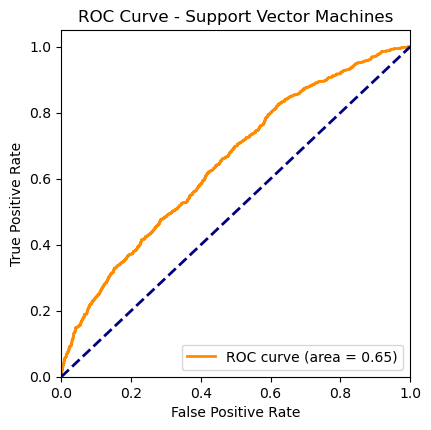

In [33]:
# Convert PySpark DataFrame to Pandas DataFrame
svm_predictions_pd = svm_predictions.select("Class", "rawPrediction").toPandas()

# Extract probability and class columns
svm_probs = np.array(svm_predictions_pd[["Class", "rawPrediction"]].apply(lambda row: (float(row['rawPrediction'][1]), float(row['Class'])), axis=1).tolist())

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(svm_probs[:,1], svm_probs[:,0])  # Use svm_probs consistently
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4.5, 4.5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machines')
plt.legend(loc="lower right")
plt.show()

# STEP 5: Summary of Model Evaluation

We analyze the performance of our model using MAE, RMSE, and R-Squared for the regression models (Linear regression, gradient-boosted trees, and random forest) and AUC for the classification methods (Naive Bayes and SVM)

## Linear Regression


### Historical Data with Target Adjusted Close:

**MAE:** 0.604648805782189

**Root Mean Squared Error:** 0.9042864982889584

**R Squared:** 0.9966179141073948

### Historical Data with Target Rate of Return:

**MAE:** 0.15767139054082255

**Root Mean Squared Error:** 0.19474760395577043

**R Squared:* 0.06363238971933338

### Financial Earnings Data on subset of columns with Target Adjusted Close:

**MAE:** 2.348287027912123

**Root Mean Squared Error:** 3.243875140132284

**R Squared:* 0.955447565922012

### Financial Earnings Data on subset of columns with Target Rate of Return:

**MAE:** 0.14857002564092667

**Root Mean Squared Error:** 0.18369063024721355

**R Squared:** -0.004431304355283272


## Gradient-boosted Trees


### Historical Data:

**MAE:** 0.6114910290272416

**RMSE:** 1.2218787260313106

**R-Squared:** 0.9939558889753741

### Financial Earnings Data (all columns)

**MAE:** 2.8027980701128072

**RMSE:** 3.273395774607916

**R-Squared:** 0.8830425082293992

### Financial Earnings Data (Open, High, Low, Volume)

**MAE:** 1.2661382181683607

**RMSE:** 1.6245708867863211

**R-Squared:** 0.9863670080970188

## Random Forest

### Historical Data

**MAE:** 0.7414244654392196

**RMSE:** 1.3519378238073987

**R-Squared:** 0.9926007165614084

### Financial Earnings Data (all columns)

**MAE:** 1.0021435858636547

**RMSE:** 1.2651000115524824

**R-Squared:** 0.991732702542472

### Financial Earnings Data (top 4 importance features)

**MAE:** 1.0611790795516813

**RMSE:** 1.5347088399079443

**R-Squared:** 0.9878334951454119


## Naive Bayes

**Area under ROC:** 0.52

## Support Vector Machine (SVM)

**Area under ROC:** 0.65
